<a href="https://colab.research.google.com/github/r0b0shubham96/Google_colab/blob/main/Mvsnet_Run3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript(''' 
function Clickconnect() {
  btn = document.querySelector("colab-connect-button")
  if (btn != null){
    console.log("Click colab-connect-button");
    btn.click()
  }

  btn = document.getElementbyID('ok')
  if (btn != null){
    console.log("Click reconnect");
    btn.click()
  }
}
setInterval(Clickconnect,50000)
'''))

<IPython.core.display.Javascript object>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unrar x "/content/drive/MyDrive/Dataset/dtu_training.rar" "/media/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Dataset/dtu_training.rar


Would you like to replace the existing file /media/mvs_training/dtu/Cameras/00000000_cam.txt
   200 bytes, modified on 2018-01-09 20:56
with a new one
   200 bytes, modified on 2018-01-09 20:56

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [4]:
import sys
sys.path.insert(0, '/home/mvsnet/')

In [5]:
import preprocess
import visualize
import torch
import model
import loss as l
from torchvision import transforms
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import math
import constants

In [6]:
#Hyper parameters 
BATCH_SIZE = 5
WEIGHT_DECAY = 1e-3
LEARNING_RATE = 1e-4
TRANSFORMS = preprocess.ToTensor()      #dataset_transforms = transforms.Compose([preprocess.SampleWiseStandardization(), preprocess.ToTensor()])

#Dataloader
NUM_WORKERS = 3

#Training
MAX_EPOCHS = 10


In [7]:
sample_list_train = preprocess.gen_dtu_path("/media/mvs_training/dtu/")  #Change path to your own directory of the DTU dataset
sample_list_val = preprocess.gen_dtu_path("/media/mvs_training/dtu/", mode="validation")

#dataset_transforms = transforms.Compose([preprocess.SampleWiseStandardization(), preprocess.ToTensor()])
data_train = preprocess.DTUDatset(sample_list_train, transform=TRANSFORMS)
data_val = preprocess.DTUDatset(sample_list_val, transform=TRANSFORMS)

In [8]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
loader_val = torch.utils.data.DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


In [9]:
MVSModel = model.NeuralNet()
MVSModel = MVSModel.float()


def one_epoch(model, data_loader, optimizer=None, best_val_acc = 0):
    """
    Outputs the mean loss and acc for every 1000 iterations / ref images.
    The returned output is a vector of length 27,
    that is 27 mean loss and acc values. 
    The last index of the list contains a mean over 1097 iterations due to the 
    total lenght of the data in the dataloader is 27097 
    """
    device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train = False if optimizer is None else True
    model.train() if train else model.eval()    #When model is set to train it knows to enclude dropout, batchnorm, etc in the training
    mean_losses, mean_acc, accuracies, losses, acc, correct, total = [], [], 0, [], 0, 0, 0
    log_iter = 100 * BATCH_SIZE #Number of iterations before we log loss and acc
    max_iter = 27097 
    iteration = 0
    depth_maps = []
    for ref, s1, s2, gt_depth, r_cam, s1_cam, s2_cam in data_loader:
        start_time = time.time()
        iteration += len(ref)
        ref, s1, s2, gt_depth = ref.to(device), s1.to(device), s2.to(device), gt_depth.to(device)
        with torch.set_grad_enabled(train): #Enable gradient calculation if train = True
            logits = model(ref.float(), s1.float(), s2.float(), r_cam, s1_cam, s2_cam)
        #ATM the loss can not be computed since the model is not finished, therefore the loop stops when trying to implement the backward pass
        loss, acc = l.mean_abs_diff_loss(logits, gt_depth)
        if train: 
            optimizer.zero_grad()   #Removing accumulated gradients 
            loss.backward()         #Calculating new gradients
            optimizer.step()        #Updating weights
        losses.append(loss.item())
        accuracies += acc
        total += len(ref)   
        if iteration % log_iter == 0 and iteration < 27000:
            mean_losses.append(np.mean(losses))
            mean_acc.append(accuracies/log_iter)
            if not train:
                #Saving est_depth_map, gt_depth_map and ref image in the validation loop
                est_depth_map = logits
                est_depth_map = est_depth_map.detach().cpu().numpy()
                gt = gt_depth
                gt = gt.detach().cpu().numpy()
                ref_img = ref
                ref_img = ref_img.detach().cpu().numpy()
                est_and_gt = [est_depth_map, gt, ref_img]
                depth_maps.append(est_and_gt)
                #Checking if current acc is better than current best acc
                if acc > best_val_acc:
                    best_val_acc = acc
                    print("New best validation acc: ", best_val_acc)
                    torch.save(model.state_dict(), "/home/mvsnet/best_model_param.pt") #saving best model parameters
            losses = []
            accuracies = 0
        elif iteration == max_iter:   #End of the epoch
            print("THIS IS THE END OF THE EPOCH")
            mean_losses.append(np.mean(losses))
            mean_acc.append(accuracies/log_iter)
            if not train:
                if acc > best_val_acc:
                    best_val_acc = acc
                    print("New best validation acc: ", best_val_acc)
                    torch.save(model.state_dict(), "/home/mvsnet/best_model_param.pt") #saving best model parameters
        print("Iteration: ", iteration, "     Current loss: ", loss.item(), "     Current accuracy: ", np.mean(accuracies),  "     Comp_time of one batch: ", start_time - time.time())
 
    if train:
        return mean_losses, mean_acc
    else:
        return mean_losses, mean_acc, best_val_acc, depth_maps



def train(model, loader_train, loader_val, lr=1e-3, max_epochs = 6, weight_decay=1e-2, patience=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    depth_maps_val = []
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_epochs = []
    best_val_acc = 0
    t = tqdm(range(max_epochs)) #Using tqdm to show progress of epochs
    for epoch in t:
        train_loss, train_acc = one_epoch(model, loader_train, opt) #One epoch returns 27 mean values. 
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, best_val_acc, depth_map_val = one_epoch(model, loader_val, best_val_acc=best_val_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        best_val_epochs.append(best_val_acc)
        depth_maps_val.append(depth_map_val)
        

    train_losses_flat = [item for sublist in train_losses for item in sublist]
    val_losses_flat = [item for sublist in val_losses for item in sublist]
    train_accuracies = [item for sublist in val_losses for item in sublist]
    val_accuracies = [item for sublist in val_losses for item in sublist]

        #t.set_description(f'train_acc: {train_acc:.2f}, valid_acc: {val_acc:.2f}, best_val_acc: {best_val_acc:.2f}')
    return train_losses_flat, train_accuracies, val_losses_flat, val_accuracies, depth_maps_val




def plot_history(train_losses, train_accuracies, val_losses, val_accuracies):
    fig = plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="valid")
    #plt.ylim()    
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.plot(train_accuracies, label="train")
    plt.plot(val_accuracies, label="valid")
    #plt.ylim()
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    fig.savefig("/home/train_results.png")

    


In [10]:
loss_train, acc_train, loss_val, acc_val, depth_maps = train(MVSModel, loader_train, loader_val, lr=LEARNING_RATE, max_epochs=MAX_EPOCHS, weight_decay=WEIGHT_DECAY)



  0%|          | 0/10 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Iteration:  8285      Current loss:  35.280086517333984      Current accuracy:  18.0      Comp_time of one batch:  -0.8837466239929199
Iteration:  8290      Current loss:  16.867923736572266      Current accuracy:  19.0      Comp_time of one batch:  -0.9035298824310303
Iteration:  8295      Current loss:  22.85218620300293      Current accuracy:  20.0      Comp_time of one batch:  -0.8791368007659912
Iteration:  8300      Current loss:  21.243061065673828      Current accuracy:  21.0      Comp_time of one batch:  -0.8807404041290283
Iteration:  8305      Current loss:  29.7011661529541      Current accuracy:  21.0      Comp_time of one batch:  -0.8910517692565918
Iteration:  8310      Current loss:  23.572891235351562      Current accuracy:  21.0      Comp_time of one batch:  -0.8833727836608887
Iteration:  8315      Current loss:  24.48434066772461      Current accuracy:  22.0      Comp_time of one batch:  -0.9024112224578857
Iteratio

In [17]:
import os

for e in range(len(depth_maps)):
    os.mkdir("/home/epoch%1d" % e)
    for i in range(len(depth_maps[0])):
        for j in range(len(depth_maps[0][0])):
            est_map = depth_maps[0][i][0][j]
            gt_map = depth_maps[0][i][1][j]
            ref = depth_maps[0][i][2][j]
            ref = np.swapaxes(ref, 0, 1)
            ref = np.swapaxes(ref,1, 2)
            #ref = np.uint8(ref)
            visualize.show_depth_img(est_map, "epoch%1d/" % e + "est%1d" % i)
            visualize.show_depth_img(gt_map,"epoch%1d/" % e + "gt%1d" % i)
            plt.imshow(ref)
            plt.savefig("/home/epoch%1d/" % e + "ref%1d" % i)
            plt.show(block=True)


     

FileExistsError: ignored

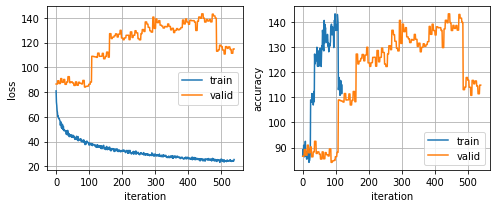

In [13]:
#come up with something better at some point
expanded_val_loss = []
expanded_val_acc = []
for i in range(len(loss_val)):
    expanded_val_loss.append(loss_val[i])
    expanded_val_loss.append(loss_val[i])
    expanded_val_loss.append(loss_val[i])
    expanded_val_loss.append(loss_val[i])
    expanded_val_acc.append(acc_val[i])
    expanded_val_acc.append(acc_val[i])
    expanded_val_acc.append(acc_val[i])
    expanded_val_acc.append(acc_val[i])
    if i % 2 == 0:
        expanded_val_loss.append(loss_val[i])
        expanded_val_acc.append(acc_val[i])

plot_history(loss_train, acc_train, expanded_val_loss, expanded_val_acc)

In [14]:
file = open("/home/best results.txt", "w+")
file.write("train_acc: " + str(max(acc_train)) + "    index: " + str(np.argmax(acc_train)*300) + "\n")
file.write("val_acc: " + str(max(acc_val)) + "    index: " + str(np.argmax(acc_val)*300) + "\n")
file.close()

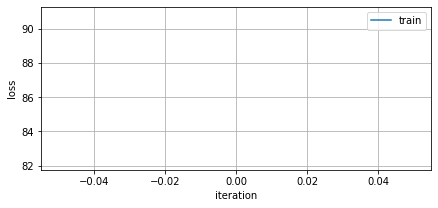

In [16]:
fig = plt.figure(figsize=(7, 3))
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(acc_train[0], label="train")
#plt.ylim()    
plt.legend()
plt.grid()



In [ ]:
while True:pass